# Summary of the Code

## 1. Data Preprocessing
- **Data Loading**:
  - The dataset is downloaded from Kaggle and extracted if not already present.
  - Training and test series are loaded using `pyarrow` for efficient data handling.

- **Handling Missing Data**:
  - Missing values in critical columns (`anglez`, `enmo`, `date_time`) are dropped during preprocessing.

- **Tolerance Labelling**:
  - Data is truncated around the events 'onset' and wakeup to handle class imabalances.
  - Events (`onset` and `wakeup`) are labeled using two approaches:
    - **Hard Labels**: Events are spread over a window (`2 * decay + 1`).
    - **Soft Labels**: Linear decay is applied to event probabilities over a specified window, ensuring smooth transitions.

- **Event Extraction**:
  - Data is sliced around events with padding to focus on relevant time windows.

---

## 2. Feature Engineering
- **Time-Based Features**:
  - Extracted components like `hour`, `minute`, and `month` from the `date_time` column.
  - Cyclic encodings (`sin` and `cos`) for time-based features to capture periodicity.

- **Lag/Lead Features**:
  - Differences between consecutive values (`lag_diff` and `lead_diff`) for `anglez` and `enmo`.

- **Rolling Statistics**:
  - Calculated rolling mean, max, and standard deviation over a 60-step window for `anglez` and `enmo`.

- **Normalization**:
  - Features are normalized to a range of `[0, 1]` for consistent scaling.

---

## 3. Model Architecture
- **BiLSTM Classifier**:
  - A bidirectional LSTM (BiLSTM) is used to capture temporal dependencies in the data.
  - The architecture includes:
    - **LSTM Layer**: Bidirectional LSTM with hidden states concatenated.
    - **Fully Connected Layer**: Maps the concatenated hidden states to class probabilities.

- **Training Setup**:
  - Input sequences are created with a fixed length (`seq_len`).
  - Data is split into training (80%) and validation (20%) sets.
  - Loss function: Cross-Entropy Loss.
  - Optimizer: AdamW with a learning rate of `1e-3`.

---

## 4. Evaluation
- **Metrics**:
  - Accuracy, Precision, Recall, and F1-Score (macro and class-wise) are computed for validation.
  - Class-wise metrics are tracked across epochs.

- **Visualization**:
  - Training and validation loss curves are plotted to monitor convergence.
  - Class-wise precision and validation metrics (accuracy, precision, recall, F1) are visualized over epochs.
  - Predictions vs. actual labels are plotted for qualitative evaluation.

---

This pipeline effectively preprocesses the data, engineers meaningful features, trains a BiLSTM model, and evaluates its performance using robust metrics and visualizations.

## Importing libraries and setting up directories 

In [11]:
# Cell 1: Imports & Configuration
import os, zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display, Markdown
from kaggle.api.kaggle_api_extended import KaggleApi
import pyarrow.dataset as ds
from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Paths & constants
BASE_DIR      = r"C:\Users\ASUS\Desktop"
DATA_ZIP      = os.path.join(BASE_DIR, "child-mind-institute-detect-sleep-states.zip")
DATA_DIR      = os.path.join(BASE_DIR, "child-mind-institute-detect-sleep-states")
TRAIN_SER     = os.path.join(DATA_DIR, "train_series.parquet")
TRAIN_EVT     = os.path.join(DATA_DIR, "train_events.csv")
TEST_SER      = os.path.join(DATA_DIR, "test_series.parquet")
CACHE_DIR     = os.path.join(BASE_DIR, "cache")
os.makedirs(CACHE_DIR, exist_ok=True)

In [12]:
# Cell 2: Download & Unzip (runs only if data missing)
if not os.path.isdir(DATA_DIR):
    api = KaggleApi()
    api.authenticate()
    api.competition_download_files(
        "child-mind-institute-detect-sleep-states",
        path=BASE_DIR,
        quiet=False
    )
    with zipfile.ZipFile(DATA_ZIP, "r") as zf:
        zf.extractall(path=BASE_DIR)
    print("✅ Downloaded and extracted to", DATA_DIR)
else:
    print("🔁 Data already present at", DATA_DIR)


OSError: Could not find kaggle.json. Make sure it's located in /home/manoj/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/

## Preprocessing(1)



In [18]:
# Cell 3 (fix load_events only)

import pyarrow.dataset as ds

# Cache for pyarrow datasets
_dataset_cache = {}
def _get_dataset(path):
    if path not in _dataset_cache:
        _dataset_cache[path] = ds.dataset(path, format="parquet")
    return _dataset_cache[path]

def load_series(series_id, train=True):
    path = TRAIN_SER if train else TEST_SER
    table = _get_dataset(path).to_table(filter=(ds.field("series_id")==series_id))
    df = table.to_pandas()
    if "date_time" not in df.columns:
        df["date_time"] = pd.to_datetime(df["timestamp"], utc=True).dt.tz_convert(None)
        df.drop(columns="timestamp", inplace=True)
    return df

# Pre-load events once with robust parsing
_events_df = None
def load_events():
    global _events_df
    if _events_df is None:
        ev = pd.read_csv(TRAIN_EVT)
        # Explicit parse
        ev["date_time"] = pd.to_datetime(ev["timestamp"], utc=True).dt.tz_convert(None)
        _events_df = ev.drop(columns="timestamp")
    return _events_df


Exploratory Data Analysis
1.) We noticed that there were 277 training series available. Due to lack of limited resources we used only 6 for training

In [19]:
# Cell 4: List all training series IDs
all_train_ids = (
    _get_dataset(TRAIN_SER)
    .to_table(columns=["series_id"])
    .to_pandas()["series_id"]
    .unique()
    .tolist()
)
all_test_ids = (
    _get_dataset(TEST_SER)
    .to_table(columns=["series_id"])
    .to_pandas()["series_id"]
    .unique()
    .tolist()
)
print(f"🔢 {len(all_train_ids)} training series available")
print("Sample IDs:", all_train_ids[:5])
print(f"🔢 {len(all_test_ids)} test series available")
print("Sample IDs:", all_test_ids[:5])


🔢 277 training series available
Sample IDs: ['038441c925bb', '03d92c9f6f8a', '0402a003dae9', '04f547b8017d', '05e1944c3818']
🔢 3 test series available
Sample IDs: ['038441c925bb', '03d92c9f6f8a', '0402a003dae9']


In [20]:
# Cell 5: Annotate a single series (with caching & warning suppression)
# --------------------------------------------------------------------------------
pd.set_option('future.no_silent_downcasting', True)

def get_annotated(series_id):
    cache_path = os.path.join(CACHE_DIR, f"{series_id}_annotated.csv")
    if os.path.exists(cache_path):
        return pd.read_csv(cache_path, parse_dates=["date_time"], low_memory=False)

    df = load_series(series_id)
    ev = load_events().loc[lambda d: d.series_id == series_id]

    merged = pd.merge(df, ev, on="date_time", how="outer", suffixes=("_sens","_evt"))
    # Map & downcast without warning
    merged["event"] = (
        merged["event"]
        .replace({"onset": -1, "wakeup": 1})
        .infer_objects(copy=False)
    )
    merged["event"] = merged["event"].fillna(0).astype(float)
    merged["night"] = merged["night"].ffill().bfill().interpolate().round()

    merged.to_csv(cache_path, index=False)
    return merged

# Quick preview
sample_id = all_train_ids[0]
sample_df = get_annotated(sample_id)
display(sample_df)


,series_id_sens,step_sens,anglez,enmo,date_time,series_id_evt,night,event,step_evt
0,NaN,NaN,NaN,NaN,NaT,038441c925bb,5.0,-1.0,NaN
1,NaN,NaN,NaN,NaN,NaT,038441c925bb,5.0,1.0,NaN
2,NaN,NaN,NaN,NaN,NaT,038441c925bb,9.0,-1.0,NaN
3,NaN,NaN,NaN,NaN,NaT,038441c925bb,9.0,1.0,NaN
4,NaN,NaN,NaN,NaN,NaT,038441c925bb,14.0,-1.0,NaN
...,...,...,...,...,...,...,...,...,...
389883,038441c925bb,389875.0,-27.3739,0.0110,2018-09-06 08:59:35,NaN,22.0,0.0,NaN
389884,038441c925bb,389876.0,-27.4938,0.0110,2018-09-06 08:59:40,NaN,22.0,0.0,NaN
389885,038441c925bb,389877.0,-27.5337,0.0111,2018-09-06 08:59:45,NaN,22.0,0.0,NaN
389886,038441c925bb,389878.0,-28.0036,0.0111,2018-09-06 08:59:50,NaN,22.0,0.0,NaN


Visualization

We visualized the features enmo and anglez after normalizing them vs time 

### Series 08db4255286f — Night 1

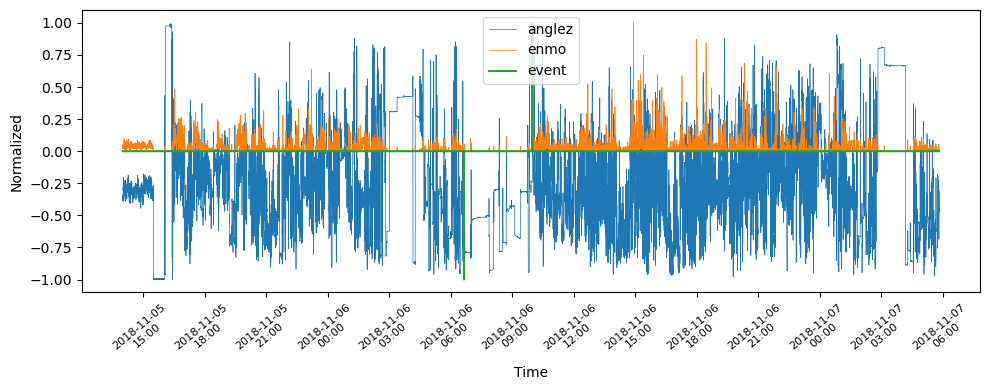

In [70]:
# Cell 6: Visualization helper
# --------------------------------------------------------------------------------
def visualize_nights(df, series_id):
    sub = df[df.night == 1].copy()
    for col in ("anglez","enmo","event"):
        m = sub[col].abs().max() or 1e-10
        sub[col] = sub[col] / m
    if sub.event.max() == 1:
        display(Markdown(f"### Series {series_id} — Night {int(1)}"))
        fig, ax = plt.subplots(figsize=(10,4))
        ax.plot(sub.date_time, sub.anglez, label="anglez", linewidth=0.5)
        ax.plot(sub.date_time, sub.enmo,  label="enmo",  linewidth=0.5)
        ax.plot(sub.date_time, sub.event,  label="event")
        ax.legend(); ax.set_ylabel("Normalized"); ax.set_xlabel("Time")
        ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0,24,3)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d\n%H:%M"))
        plt.xticks(rotation=40, fontsize=8); plt.tight_layout(); plt.show()

# Demo
visualize_nights(get_annotated("08db4255286f"), "08db4255286f")


Feature Engineering

we created various features based on our 2 features for extra 

In [40]:
import numpy as np
import pandas as pd

def create_features(df):
    # Drop rows where anglez or enmo is missing
    df = df.dropna(subset=['anglez', 'enmo', 'date_time']).copy()

    # Ensure datetime
    df['date_time'] = pd.to_datetime(df['date_time'])

    # Extract time components
    df['hour'] = df['date_time'].dt.hour
    df['minute'] = df['date_time'].dt.minute
    df['month'] = df['date_time'].dt.month

    # Lag/lead differences
    df['anglez_lag_diff'] = df['anglez'].diff(1)
    df['anglez_lead_diff'] = df['anglez'].shift(-1) - df['anglez']
    df['enmo_lag_diff'] = df['enmo'].diff(1)
    df['enmo_lead_diff'] = df['enmo'].shift(-1) - df['enmo']

    # Rolling statistics (use 60 steps ~5min window if sampled every 5s)
    df['anglez_mean_60'] = df['anglez'].rolling(window=60, min_periods=1).mean()
    df['anglez_max_60'] = df['anglez'].rolling(window=60, min_periods=1).max()
    df['anglez_std_60'] = df['anglez'].rolling(window=60, min_periods=1).std()
    df['enmo_mean_60'] = df['enmo'].rolling(window=60, min_periods=1).mean()
    df['enmo_max_60'] = df['enmo'].rolling(window=60, min_periods=1).max()
    df['enmo_std_60'] = df['enmo'].rolling(window=60, min_periods=1).std()

    # Temporal cyclic encodings
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
    df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

    return df

def make_dataset(df, label_col="event"):
    df = create_features(df)

    # Final list of features to use
    feature_cols = ['anglez', 'enmo',
                    'anglez_lag_diff', 'anglez_lead_diff', 'anglez_mean_60', 'anglez_max_60', 'anglez_std_60',
                    'enmo_lag_diff', 'enmo_lead_diff', 'enmo_mean_60', 'enmo_max_60', 'enmo_std_60',
                    'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'month_sin', 'month_cos']

    # Drop rows with any missing value (from rolling or diff)
    df = df.dropna(subset=feature_cols + [label_col])

    # Normalize
    data = df[feature_cols].values
    mn, mx = data.min(0), data.max(0)
    data = (data - mn) / (mx - mn + 1e-10)

    labels = df[label_col].values.astype(float)

    return data.astype(np.float32), labels.astype(np.float32)


In [41]:
# Cell 8: Process, Cache, Assemble, and Save with Progress Monitoring
from tqdm import tqdm

# Define window size globally
WINDOW_SIZE = 20  

# Paths for final combined tensors
FULL_X_PATH = os.path.join(CACHE_DIR, f"X_general.pt")
FULL_Y_PATH = os.path.join(CACHE_DIR, f"y_general.pt")

X_parts, y_parts = [], []
for sid in tqdm(['038441c925bb', '03d92c9f6f8a', '0402a003dae9', '08db4255286f', '0a96f4993bd7', '0cfc06c129cc'], desc="Series → Cache → Assemble"):
    # 1. Paths for per-series cache (include window size in file names)
    x_path = os.path.join(CACHE_DIR, f"{sid}_X_w{WINDOW_SIZE}.npy")
    y_path = os.path.join(CACHE_DIR, f"{sid}_y_w{WINDOW_SIZE}.npy")

    # 2. Generate per-series cache if missing
    ann = get_annotated(sid)
    X_np, y_np = make_dataset(ann)
    np.save(x_path, X_np)
    np.save(y_path, y_np)

    # 3. Append for full assembly
    X_parts.append(X_np)
    y_parts.append(y_np)

# 4. Concatenate all series into full arrays
X_np = np.concatenate(X_parts, axis=0)
y_np = np.concatenate(y_parts, axis=0)

# 5. Convert to torch tensors & save
X_general = torch.tensor(X_np, dtype=torch.float32)
y_general = torch.tensor(y_np, dtype=torch.float32)
torch.save(X_general, FULL_X_PATH)
torch.save(y_general, FULL_Y_PATH)
print("✅ Saved full tensors for reuse.")


Series → Cache → Assemble: 100%|██████████| 6/6 [00:04<00:00,  1.25it/s]


✅ Saved full tensors for reuse.


In [42]:
import torch

def extract_window_around_event(X, y, window_size=1000, offset=500):
    """
    Extracts subarrays from X and y such that each event (onset or wake) 
    is centered in a window from -500 to +500 samples.
    
    Parameters:
        X (torch.Tensor): The feature tensor of shape (num_samples, num_features)
        y (torch.Tensor): The label tensor of shape (num_samples,)
        window_size (int): The total window size to extract (default 1000 samples)
        offset (int): The offset for extracting the window around each event (default 500)
        
    Returns:
        new_X (torch.Tensor): The new tensor of features with shape (num_events, window_size, num_features)
        new_y (torch.Tensor): The new tensor of labels with shape (num_events,)
    """
    new_X = []
    new_y = []
    
    for i in range(len(y)):
        if y[i] == 0 or y[i] == 2:  # Check for event (onset or wake)
            start_idx = max(i - offset, 0)  # Ensure we do not go below index 0
            end_idx = min(i + offset + 1, len(X))  # Ensure we do not exceed the dataset
            
            # Extract the window around the event
            window_X = X[start_idx:end_idx]  # Features within the window
            window_y = y[start_idx:end_idx]  # Labels within the window
            
            # If the window is exactly 1000 samples, we can use it
            if len(window_X) == window_size:
                new_X.append(window_X)
                new_y.append(y[i])  # Label of the event (either 0 or 2)
    
    # Convert the lists back to tensors
    new_X = torch.stack(new_X)  # Shape will be (num_events, window_size, num_features)
    new_y = torch.tensor(new_y)  # Shape will be (num_events,)
    
    return new_X, new_y





Labelling approach

In [43]:
def make_tolerant_hard_labels(y_evt: np.ndarray, decay: int = 400) -> np.ndarray:
    """
    y_evt: 1D array of length N with values in {-1,0,1}
    decay: number of steps over which to tolerate the event label

    Returns:
      y_hard: 1D array of length N with values in {0,1,2}
              (0 = onset, 1 = no-event, 2 = wakeup)
              Event labels are spread over a window of size `2*decay + 1`.
              In case of overlap, event labels take priority over no-event.
              Onset and wakeup overlap resolved by latest label in window.
    """
    N = len(y_evt)
    y_hard = np.ones(N, dtype=int)  # start with all 1s (no-event)

    # Prioritize events: onset (-1) = 0, wakeup (+1) = 2
    for i, val in enumerate(y_evt):
        if val == 0:
            continue
        cls = 0 if val == -1 else 2
        for offset in range(-decay, decay+1):
            idx = i + offset
            if 0 <= idx < N:
                # Event labels overwrite no-event (1)
                # In case of conflict between onset and wakeup, later overwrite earlier
                y_hard[idx] = cls

    return torch.from_numpy(y_hard)


In [44]:
def make_linear_soft_labels(y_evt: np.ndarray, decay: int = 400) -> torch.Tensor:
    """
    y_evt: 1D array of length N with values in {-1,0,1}.
    decay: number of steps over which to linearly decay the event weight.

    Returns:
      y_soft: FloatTensor of shape (N,3) whose rows sum to 1.
        Column 0 = onset soft‐prob, column 1 = no‐event, column 2 = wakeup.
    """
    N = len(y_evt)
    # map hard classes to indices 0,1,2
    hard = np.zeros(N, dtype=int)
    hard[y_evt == -1] = 0
    hard[y_evt ==  0] = 1
    hard[y_evt == +1] = 2

    # initialize soft counts
    soft = np.zeros((N, 3), dtype=np.float32)

    # first assign full “no‐event” baseline = 1 everywhere
    soft[:,1] = 1.0

    # then for each event, carve out a linear bump
    for idx, cls in enumerate(hard):
        if cls == 1:
            continue  # no-event, keep baseline
        # build linear weights from 1→0 over next `decay` steps
        # and also backwards
        for offset in range(-decay, decay+1):
            pos = idx + offset
            if pos < 0 or pos >= N:
                continue
            w = 1.0 - abs(offset) / (decay + 1e-10)
            # subtract that mass from the no-event channel
            soft[pos,1] = max(0.0, soft[pos,1] - w)
            # add it to the event’s channel
            soft[pos, cls] += w

    # renormalize so each row sums to 1
    soft = soft / soft.sum(axis=1, keepdims=True)
    return torch.from_numpy(soft)



Loading X and y before training

In [45]:
y_evt = torch.load(os.path.join(CACHE_DIR, "y_general.pt")).numpy()
X = torch.load(os.path.join(CACHE_DIR, "X_general.pt"))

y = make_tolerant_hard_labels(y_evt, decay=400)  # shape (N,3)
# Drop any windows with NaNs
print(X.shape, y.shape)
print(X)
print(y)

mask = ~torch.isnan(X).any(dim=1)
X, y = X[mask], y[mask]
print(f"Windows after NaN drop: {X.size(0)}")

print(X.shape, y.shape)
print(X)
print(y)


torch.Size([2593068, 18]) torch.Size([2593068])
tensor([[0.5162, 0.0065, 0.5026,  ..., 0.0000, 1.0000, 0.0000],
        [0.5162, 0.0065, 0.5026,  ..., 0.0000, 1.0000, 0.0000],
        [0.5162, 0.0064, 0.5026,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.4831, 0.0213, 0.5185,  ..., 0.9973, 1.0000, 0.0000],
        [0.4715, 0.0183, 0.5176,  ..., 0.9973, 1.0000, 0.0000],
        [0.4885, 0.0128, 0.5343,  ..., 0.9973, 1.0000, 0.0000]])
tensor([1, 1, 1,  ..., 1, 1, 1], dtype=torch.int32)
Windows after NaN drop: 2593068
torch.Size([2593068, 18]) torch.Size([2593068])
tensor([[0.5162, 0.0065, 0.5026,  ..., 0.0000, 1.0000, 0.0000],
        [0.5162, 0.0065, 0.5026,  ..., 0.0000, 1.0000, 0.0000],
        [0.5162, 0.0064, 0.5026,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [0.4831, 0.0213, 0.5185,  ..., 0.9973, 1.0000, 0.0000],
        [0.4715, 0.0183, 0.5176,  ..., 0.9973, 1.0000, 0.0000],
        [0.4885, 0.0128, 0.5343,  ..., 0.9973, 1.0000, 0.0000]])
tensor([1, 1, 1,  ..., 1

Labels after tolerance

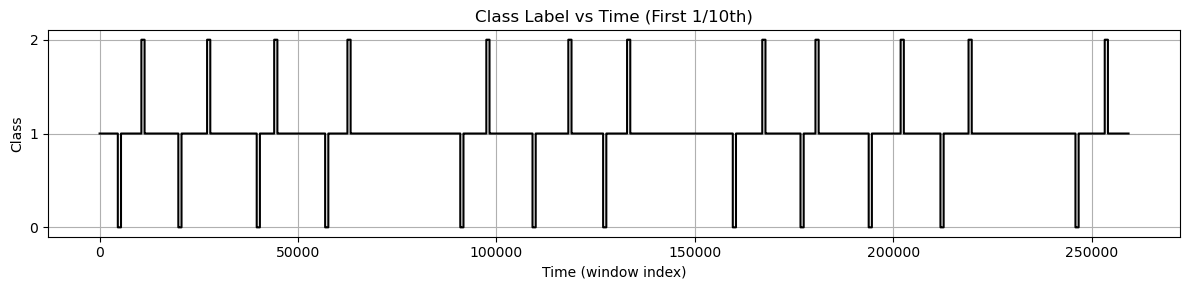

In [46]:
import matplotlib.pyplot as plt
import numpy as np

y_np = y.numpy()
N = len(y_np)
sample_len = N // 10  # take first 1/10th
time = np.arange(sample_len)

plt.figure(figsize=(12, 3))
plt.plot(time, y_np[:sample_len], drawstyle='steps-post', color='black')
plt.title("Class Label vs Time (First 1/10th)")
plt.xlabel("Time (window index)")
plt.ylabel("Class")
plt.yticks([0, 1, 2])
plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
print(X.shape)  # Should be something like [num_samples, channels, time_steps]
print(y.shape)  # Should be [num_samples] or [num_samples, ...] depending on the task

torch.Size([2593068, 18])
torch.Size([2593068])


In [48]:
def extract_event_series(X, y, padding=300, min_event_length=1):
    """
    Extract and concatenate slices of X and y around events (y != 1).

    Returns:
        X_new (torch.Tensor): Concatenated event feature slices
        y_new (torch.Tensor): Concatenated event label slices
    """
    assert X.shape[0] == y.shape[0], "X and y must have the same length"

    event_mask = (y != 1).int()
    event_diff = torch.diff(torch.cat([torch.tensor([0]), event_mask, torch.tensor([0])]))

    start_indices = (event_diff == 1).nonzero(as_tuple=True)[0]
    end_indices = (event_diff == -1).nonzero(as_tuple=True)[0]

    X_slices = []
    y_slices = []

    for start, end in zip(start_indices, end_indices):
        if (end - start) >= min_event_length:
            cut_start = max(start - padding, 0)
            cut_end = min(end + padding, len(y))
            X_slices.append(X[cut_start:cut_end])
            y_slices.append(y[cut_start:cut_end])

    if not X_slices:
        return torch.empty((0, X.shape[1])), torch.empty((0,), dtype=y.dtype)

    X_new = torch.cat(X_slices, dim=0)
    y_new = torch.cat(y_slices, dim=0)

    return X_new, y_new


In [49]:
X_new, y_new = extract_event_series(X, y, padding=500)

In [50]:
print(X_new.shape)  # Should be something like [num_samples, channels, time_steps]
print(y_new.shape)

torch.Size([381812, 18])
torch.Size([381812])


In [51]:
X = X_new
y = y_new

Labels after truncation and tolerance

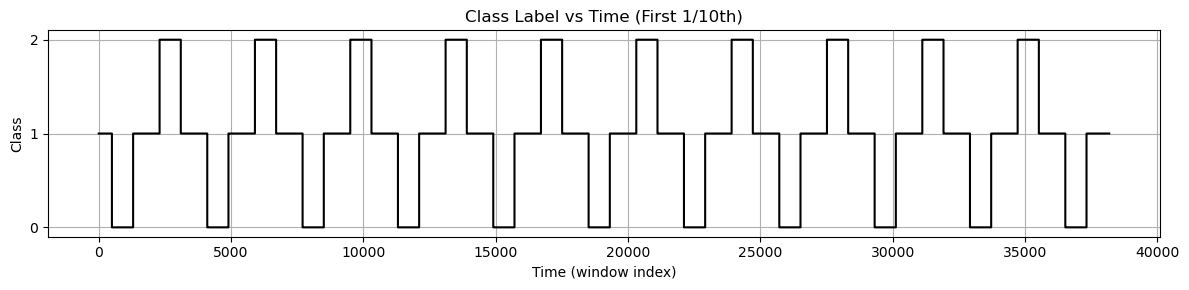

In [52]:
import matplotlib.pyplot as plt
import numpy as np

y_np = y.numpy()
N = len(y_np)
sample_len = N // 10  # take first 1/10th
time = np.arange(sample_len)

plt.figure(figsize=(12, 3))
plt.plot(time, y_np[:sample_len], drawstyle='steps-post', color='black')
plt.title("Class Label vs Time (First 1/10th)")
plt.xlabel("Time (window index)")
plt.ylabel("Class")
plt.yticks([0, 1, 2])
plt.grid(True)
plt.tight_layout()
plt.show()


models

In [59]:
def plot_predictions(model, loader, n_samples=1000):
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            pred = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.append(pred)
            all_targets.append(yb.numpy())
            if len(np.concatenate(all_preds)) >= n_samples:
                break

    preds = np.concatenate(all_preds)[:n_samples]
    targets = np.concatenate(all_targets)[:n_samples]

    plt.figure(figsize=(15, 5))
    plt.plot(targets, label="Actual", marker='o', linestyle='-', alpha=0.6)
    plt.plot(preds, label="Predicted", marker='x', linestyle='--', alpha=0.6)
    plt.legend()
    plt.title("Prediction vs Actual Labels")
    plt.xlabel("Sample Index")
    plt.ylabel("Class Label")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [60]:
import matplotlib.pyplot as plt

def plot_loss_curve(train_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, marker='o')
    plt.title("Training Loss vs Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plot it




Epoch 01 | Train Loss: 0.8052 | Val Loss: 0.6941 | Val Acc: 0.558, Macro P: 0.552, R: 0.412, F1: 0.402
    Class 0 - P: 0.609, R: 0.089, F1: 0.156
    Class 1 - P: 0.569, R: 0.845, F1: 0.680
    Class 2 - P: 0.476, R: 0.302, F1: 0.369



Epoch 02 | Train Loss: 0.7632 | Val Loss: 0.6885 | Val Acc: 0.559, Macro P: 0.524, R: 0.456, F1: 0.468
    Class 0 - P: 0.464, R: 0.230, F1: 0.308
    Class 1 - P: 0.579, R: 0.762, F1: 0.658
    Class 2 - P: 0.530, R: 0.374, F1: 0.439



Epoch 03 | Train Loss: 0.7501 | Val Loss: 0.6832 | Val Acc: 0.567, Macro P: 0.540, R: 0.482, F1: 0.499
    Class 0 - P: 0.498, R: 0.322, F1: 0.391
    Class 1 - P: 0.590, R: 0.736, F1: 0.655
    Class 2 - P: 0.533, R: 0.389, F1: 0.450



Epoch 04 | Train Loss: 0.7426 | Val Loss: 0.6860 | Val Acc: 0.548, Macro P: 0.527, R: 0.491, F1: 0.439
    Class 0 - P: 0.486, R: 0.749, F1: 0.590
    Class 1 - P: 0.583, R: 0.664, F1: 0.621
    Class 2 - P: 0.513, R: 0.060, F1: 0.107



Epoch 05 | Train Loss: 0.7376 | Val Loss: 0.6914 | Val Acc: 0.549, Macro P: 0.543, R: 0.535, F1: 0.500
    Class 0 - P: 0.477, R: 0.808, F1: 0.600
    Class 1 - P: 0.599, R: 0.580, F1: 0.589
    Class 2 - P: 0.555, R: 0.216, F1: 0.311


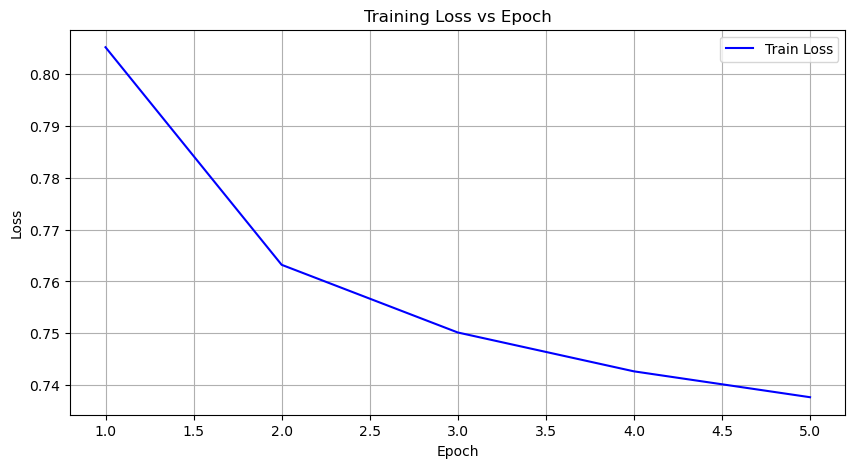

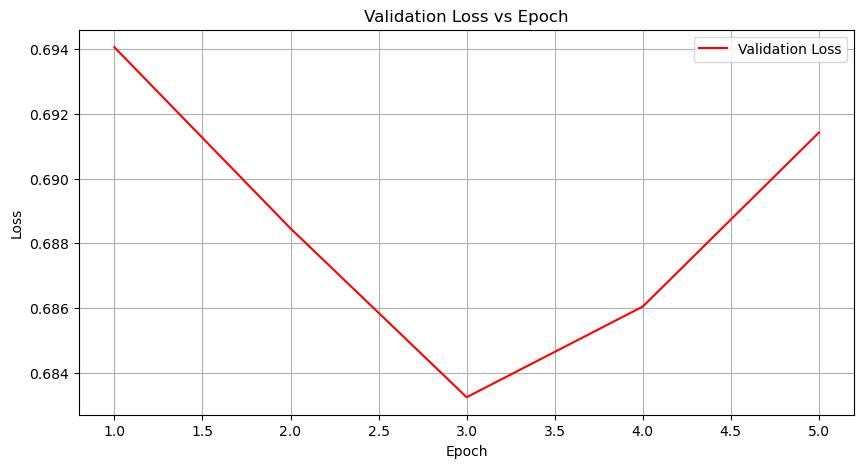

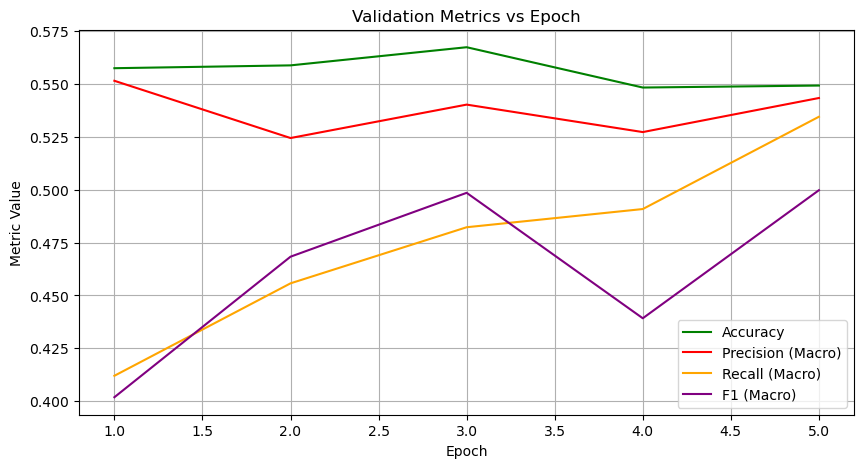

In [74]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- SETUP ---
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- INPUT ---
# Assume X: shape [N, 18], y: shape [N] with values in {0,1,2}
# X and y should already be defined

# --- PARAMETERS ---
seq_len = 100  # Sequence length
batch_size = 256
num_epochs = 5
input_size = 18  # updated input size

# --- SEQUENCE DATASET ---
class SequenceDataset(Dataset):
    def __init__(self, X, y, seq_len):
        self.X = X
        self.y = y
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        return (
            self.X[idx:idx + self.seq_len],           # shape: [seq_len, input_size]
            self.y[idx + self.seq_len - 1]            # label of last point
        )

# --- SPLIT ---
split_idx = int(0.8 * len(X))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train = y[:split_idx].long()
y_val   = y[split_idx:].long()

train_ds = SequenceDataset(X_train, y_train, seq_len)
val_ds   = SequenceDataset(X_val, y_val, seq_len)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

# --- BiLSTM MODEL ---
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size=18, hidden_size=64, num_classes=3):
        super().__init__()
        self.bilstm = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # BiLSTM -> 2 * hidden

    def forward(self, x):
        out, _ = self.bilstm(x)            # [B, T, 2*H]
        last_hidden = out[:, -1, :]        # [B, 2*H]
        return self.fc(last_hidden)        # [B, num_classes]

model = BiLSTMClassifier(input_size=input_size).to(device)

# --- LOSS AND OPTIMIZER ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# --- EVALUATION FUNCTION ---
def evaluate(loader):
    model.eval()
    preds, targets = [], []
    total_loss = 0

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            total_loss += loss.item() * xb.size(0)

            pred = torch.argmax(logits, dim=1).cpu().numpy()
            preds.append(pred)
            targets.append(yb.cpu().numpy())

    preds = np.concatenate(preds)
    targets = np.concatenate(targets)
    
    # Average validation loss
    avg_val_loss = total_loss / len(loader.dataset)

    # Macro metrics
    metrics_summary = {
        'accuracy': accuracy_score(targets, preds),
        'precision_macro': precision_score(targets, preds, average='macro', zero_division=0),
        'recall_macro': recall_score(targets, preds, average='macro', zero_division=0),
        'f1_macro': f1_score(targets, preds, average='macro', zero_division=0),
        'val_loss': avg_val_loss
    }

    # Class-wise metrics
    report = classification_report(targets, preds, output_dict=True, zero_division=0)
    for cls_id in range(3):
        cls = str(cls_id)
        metrics_summary[f'precision_{cls}'] = report[cls]['precision']
        metrics_summary[f'recall_{cls}'] = report[cls]['recall']
        metrics_summary[f'f1_{cls}'] = report[cls]['f1-score']

    return metrics_summary

# --- TRAINING LOOP ---
train_losses = []
val_losses = []  # Track validation loss
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0

    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch:02d}", leave=False):
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    # Track training loss for plotting
    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)

    # Evaluate on validation set and track validation loss
    val_metrics = evaluate(val_loader)
    val_losses.append(val_metrics['val_loss'])
    val_accuracies.append(val_metrics['accuracy'])
    val_precisions.append(val_metrics['precision_macro'])
    val_recalls.append(val_metrics['recall_macro'])
    val_f1s.append(val_metrics['f1_macro'])

    print(f"\nEpoch {epoch:02d} | Train Loss: {avg_loss:.4f} | "
          f"Val Loss: {val_metrics['val_loss']:.4f} | "
          f"Val Acc: {val_metrics['accuracy']:.3f}, "
          f"Macro P: {val_metrics['precision_macro']:.3f}, "
          f"R: {val_metrics['recall_macro']:.3f}, "
          f"F1: {val_metrics['f1_macro']:.3f}")

    for cls_id in range(3):
        print(f"    Class {cls_id} - "
              f"P: {val_metrics[f'precision_{cls_id}']:.3f}, "
              f"R: {val_metrics[f'recall_{cls_id}']:.3f}, "
              f"F1: {val_metrics[f'f1_{cls_id}']:.3f}")

# --- PLOT TRAINING LOSS vs EPOCH ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# --- PLOT VALIDATION LOSS vs EPOCH ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# --- PLOT VAL METRICS vs EPOCH ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Accuracy', color='green')
plt.plot(range(1, num_epochs + 1), val_precisions, label='Precision (Macro)', color='red')
plt.plot(range(1, num_epochs + 1), val_recalls, label='Recall (Macro)', color='orange')
plt.plot(range(1, num_epochs + 1), val_f1s, label='F1 (Macro)', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Validation Metrics vs Epoch')
plt.legend()
plt.grid(True)
plt.show()


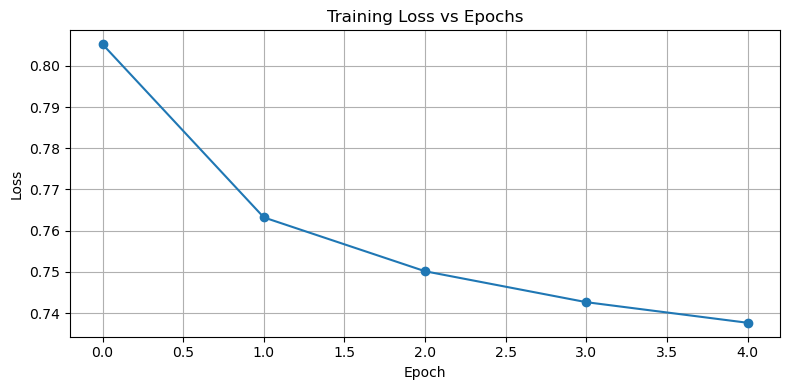

In [75]:
plot_loss_curve(train_losses)

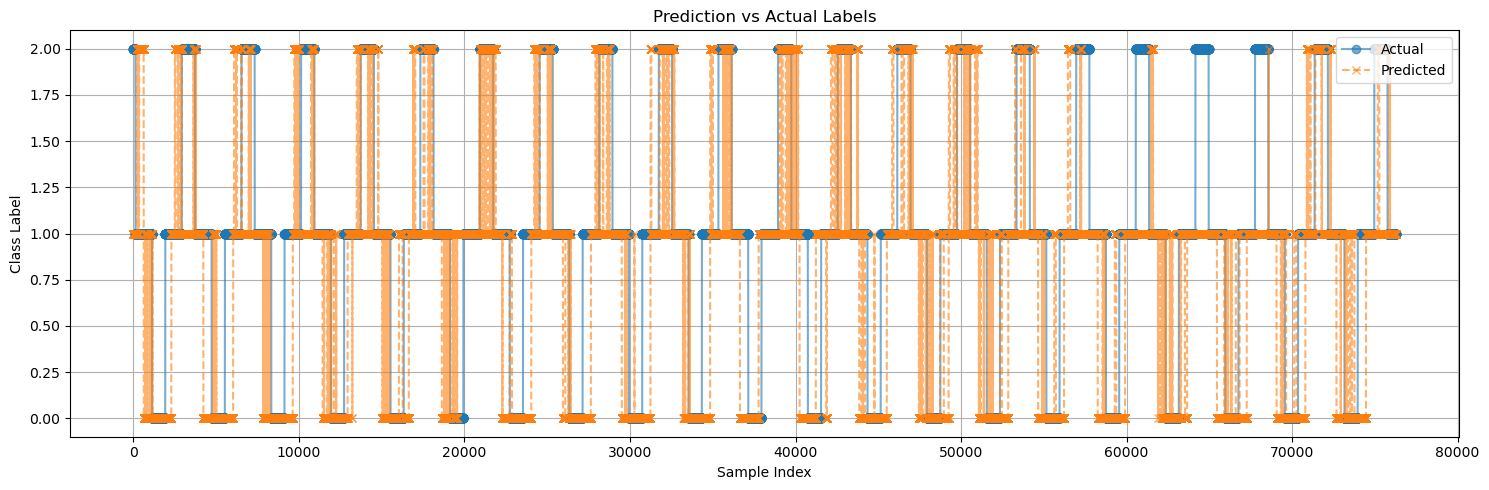

In [76]:
plot_predictions(model, val_loader, n_samples=100000)

Epoch 1/5: 100%|███████████████████████████████████| 1194/1194 [00:09<00:00, 130.15it/s, loss=0.791]


Epoch 1 Metrics:
Train Loss: 0.7914 | Validation Loss: 0.6978
Validation Accuracy: 0.5517 | Precision: 0.5241 | Recall: 0.4779 | F1 Score: 0.4797


Epoch 2/5: 100%|████████████████████████████████████| 1194/1194 [00:08<00:00, 141.57it/s, loss=0.76]


Epoch 2 Metrics:
Train Loss: 0.7595 | Validation Loss: 0.6837
Validation Accuracy: 0.5812 | Precision: 0.5651 | Recall: 0.4830 | F1 Score: 0.4942


Epoch 3/5: 100%|███████████████████████████████████| 1194/1194 [00:08<00:00, 140.19it/s, loss=0.747]


Epoch 3 Metrics:
Train Loss: 0.7470 | Validation Loss: 0.6817
Validation Accuracy: 0.5776 | Precision: 0.5717 | Recall: 0.5171 | F1 Score: 0.5054


Epoch 4/5: 100%|████████████████████████████████████| 1194/1194 [00:08<00:00, 142.72it/s, loss=0.74]


Epoch 4 Metrics:
Train Loss: 0.7397 | Validation Loss: 0.6824
Validation Accuracy: 0.5668 | Precision: 0.5427 | Recall: 0.5084 | F1 Score: 0.5207


Epoch 5/5: 100%|███████████████████████████████████| 1194/1194 [00:08<00:00, 139.57it/s, loss=0.735]


Epoch 5 Metrics:
Train Loss: 0.7347 | Validation Loss: 0.6846
Validation Accuracy: 0.5530 | Precision: 0.5556 | Recall: 0.5246 | F1 Score: 0.4900


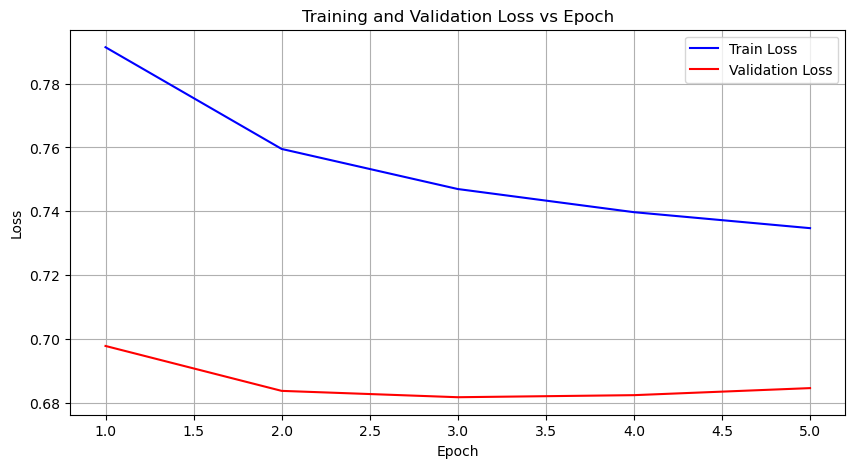

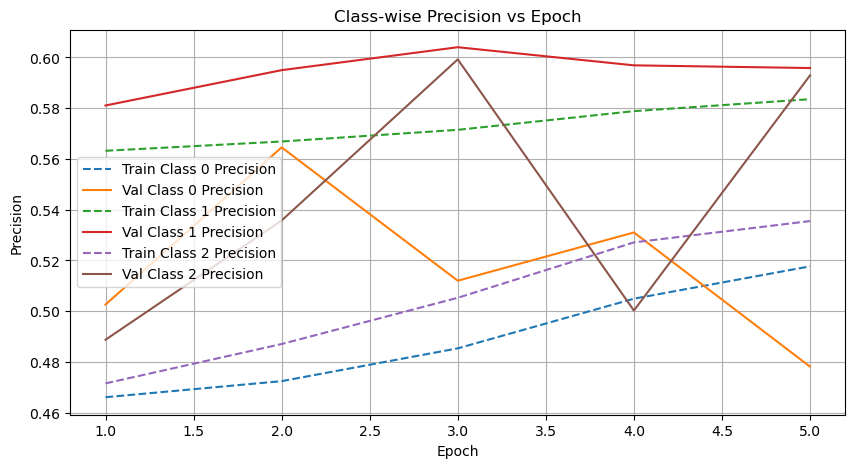

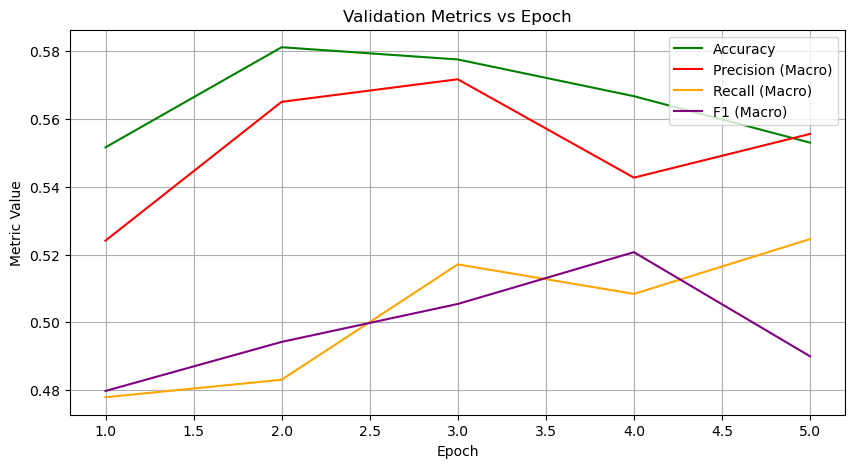

Final Evaluation Metrics:
Class 0: Precision: 0.5146, Recall: 0.4756, F1 Score: 0.4943
Class 1: Precision: 0.5910, Recall: 0.7548, F1 Score: 0.6629
Class 2: Precision: 0.5643, Recall: 0.2168, F1 Score: 0.3132
Final Accuracy: 57.29892715314177%


In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# Define the BiLSTM model
class BiLSTMEventDetection(nn.Module):
    def __init__(self, input_size, num_classes, lstm_hidden_size=128, lstm_num_layers=1):
        super(BiLSTMEventDetection, self).__init__()

        # LSTM Layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=lstm_hidden_size, num_layers=lstm_num_layers, 
                            batch_first=True, bidirectional=True)  # Bidirectional LSTM
        
        # Fully Connected Layer for classification
        self.fc = nn.Linear(lstm_hidden_size * 2, num_classes)  # Multiply by 2 because of bidirectionality

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        
        # LSTM: Capture long-term dependencies (Bidirectional)
        lstm_out, (hn, cn) = self.lstm(x)
        
        # Use the last hidden state from both directions for classification
        final_hidden_state = torch.cat((hn[-2], hn[-1]), dim=-1)  # Concatenate forward and backward states
        
        # Classification: Pass through fully connected layer
        output = self.fc(final_hidden_state)
        
        return output



# Reshaping X to (N, 1, 18) because it's a sequence with 1 time step and 18 features
X = X.view(X.size(0), 1, -1)

# Split data into training and validation sets (80-20 split for example)
split_idx = int(0.8 * len(X))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

# Create DataLoader for training and validation
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMEventDetection(input_size=18, num_classes=3)  # 18 features as input size, 3 classes
model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- TRACKING VARIABLES ---
train_losses = []
val_losses = []
val_accuracies = []
val_precisions = []
val_recalls = []
val_f1s = []
classwise_train_precisions = {i: [] for i in range(3)}  # Store precision for each class during training
classwise_val_precisions = {i: [] for i in range(3)}    # Store precision for each class during validation

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    # Initialize tqdm for progress bar
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", ncols=100)
    
    for xb, yb in loop:
        xb, yb = xb.to(device), yb.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(xb)
        
        # Calculate loss
        loss = criterion(logits, yb)
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        running_loss += loss.item()
        
        # Collect predictions and labels for metrics calculation
        _, predicted = torch.max(logits, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

        # Update the progress bar
        loop.set_postfix(loss=running_loss / len(train_loader))

    # Track training loss
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Compute training metrics
    precision_train = precision_score(all_labels, all_preds, average=None)
    recall_train = recall_score(all_labels, all_preds, average=None)
    f1_train = f1_score(all_labels, all_preds, average=None)
    
    # Store class-wise precision during training
    for i in range(3):
        classwise_train_precisions[i].append(precision_train[i])

    # Validation evaluation
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = criterion(logits, yb)
            val_loss += loss.item()
            
            # Collect predictions and labels
            _, predicted = torch.max(logits, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(yb.cpu().numpy())

    # Track validation loss
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Compute validation metrics
    accuracy = accuracy_score(val_labels, val_preds)
    precision_val = precision_score(val_labels, val_preds, average=None)
    recall_val = recall_score(val_labels, val_preds, average=None)
    f1_val = f1_score(val_labels, val_preds, average=None)
    
    # Store class-wise precision during validation
    for i in range(3):
        classwise_val_precisions[i].append(precision_val[i])

    # Track validation metrics
    val_accuracies.append(accuracy)
    val_precisions.append(precision_val.mean())
    val_recalls.append(recall_val.mean())
    val_f1s.append(f1_val.mean())

    # Print metrics for the current epoch
    print(f"Epoch {epoch+1} Metrics:")
    print(f"Train Loss: {avg_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
    print(f"Validation Accuracy: {accuracy:.4f} | Precision: {precision_val.mean():.4f} | Recall: {recall_val.mean():.4f} | F1 Score: {f1_val.mean():.4f}")

# --- PLOT TRAINING AND VALIDATION LOSS vs EPOCH ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# --- PLOT CLASS-WISE PRECISION vs EPOCH ---
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(range(1, epochs + 1), classwise_train_precisions[i], label=f'Train Class {i} Precision', linestyle='dashed')
    plt.plot(range(1, epochs + 1), classwise_val_precisions[i], label=f'Val Class {i} Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Class-wise Precision vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# --- PLOT VALIDATION METRICS vs EPOCH ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), val_accuracies, label='Accuracy', color='green')
plt.plot(range(1, epochs + 1), val_precisions, label='Precision (Macro)', color='red')
plt.plot(range(1, epochs + 1), val_recalls, label='Recall (Macro)', color='orange')
plt.plot(range(1, epochs + 1), val_f1s, label='F1 (Macro)', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Validation Metrics vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# --- FINAL EVALUATION ---
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        
        logits = model(xb)
        
        # Get predictions
        _, predicted = torch.max(logits, 1)
        total += yb.size(0)
        correct += (predicted == yb).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

# Compute final evaluation metrics
precision = precision_score(all_labels, all_preds, average=None)
recall = recall_score(all_labels, all_preds, average=None)
f1 = f1_score(all_labels, all_preds, average=None)

print(f"Final Evaluation Metrics:")
for i in range(3):  # Assuming 3 classes
    print(f"Class {i}: Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1 Score: {f1[i]:.4f}")

print(f"Final Accuracy: {100 * correct / total}%")


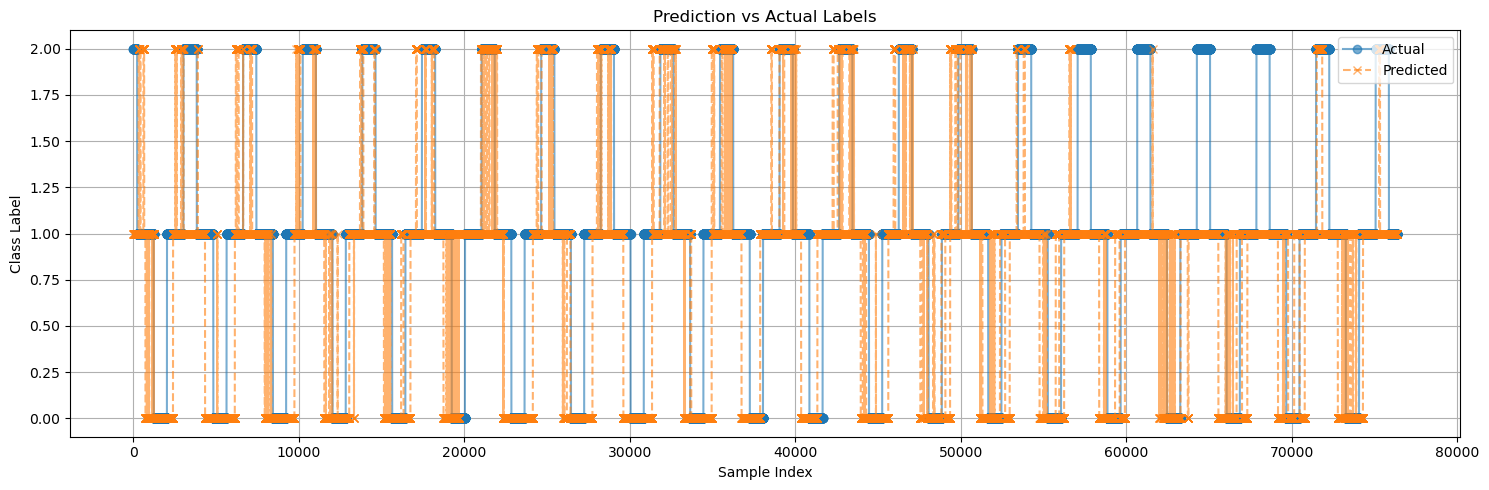

In [81]:
plot_predictions(model, val_loader, n_samples=100000)